# Poisson Blending
in this question we want to use Poisson method in order to blend two images 
to do so, we have to follow some essential steps:

1) first, take a laplacian of interpolant image 

2) make a coefficient matrix in order to solve Poisson equation with Dirichlet condition (solve it in the form of a matrix)

3) after making coefficient matrix,use pre_defined function from scipy to solve the system of linear equations . 

4) resize the column vector(result) in order to have same size with original images . 


### take a laplacian of interpolant image 
to take laplacian of image we use 3*3 filter

[[0, 1, 0],

[1, -4, 1],

[0, 1, 0]]

and convolve this kernel with source and interpolant image using `scipy.signal.convolve2d`
you can see the code and result of taking laplacian : 


In [81]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
import scipy.sparse
from skimage.filters import threshold_yen
import scipy.signal

#### laplacian code : 

In [82]:
def laplacian(img):           # creat laplacian of image
    edge_filter = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

    r1 = scipy.signal.convolve2d(img[:, :, 0], edge_filter, mode='same')
    g1 = scipy.signal.convolve2d(img[:, :, 1], edge_filter, mode='same')
    b1 = scipy.signal.convolve2d(img[:, :, 2], edge_filter, mode='same')

    return r1, g1, b1


#### original images : 

Text(0.5, 1.0, 'mask')

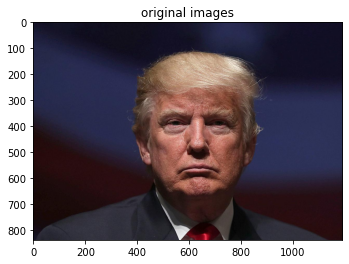

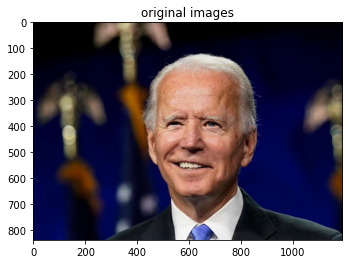

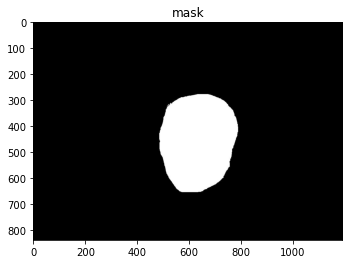

In [83]:
source_image = cv2.imread('res06_5.jpg')
source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)
source_image = np.array(source_image)

des = cv2.imread('res05_5.jpg')
des = cv2.cvtColor(des, cv2.COLOR_BGR2RGB)
des = np.array(des)

mask = cv2.imread('mask_q2.jpg')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask = np.array(mask)


plt.figure(1)
plt.imshow(source_image)
plt.title("original images")

plt.figure(2)
plt.imshow(des)
plt.title("original images")


plt.figure(3)
plt.imshow(mask)
plt.title("mask")



#### visualization of laplacian 
to visualize Laplacian of image i normalize it and then show it (note that real value of laplacian is not the value of each pixel and it is just a visualization!)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'laplacian of interpolant image')

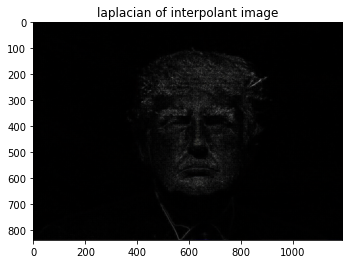

In [84]:
#  -----get source image
#  destination image
#  and mask
source_image = cv2.imread('res06_5.jpg').astype(np.int16)
source_image = np.array(source_image)

des = cv2.imread('res05_5.jpg').astype(np.int16)
des = np.array(des)

mask = cv2.imread('mask_q2.jpg').astype(np.int16)

# ----------------

[row, colum, c3] = des.shape
[c1, c2, c4] = source_image.shape


r, g, b = cv2.split(des)


source_new = np.zeros_like(des)


r_lap, g_lap, b_lap = laplacian(source_image)
n = row*colum

temp=cv2.merge((r_lap,g_lap,b_lap))
temp =temp/np.max(temp)    
plt.imshow(np.abs(temp))    
plt.title("laplacian of interpolant image")

## make a coefficient matrix in order to solve Poisson equation
because these method of solving problem needs a big matrix we can solve it using numpy ,....
so we use sparse matrix from `scipy.sparse` library . using this kind of matrix accelerate our calculation . 

## coefficient matrix for the index of mask 
as mentioned in class before for the pixels that are in the interpolant area , laplacian of pixels should be equal to laplacian of image that we want to fill the hole with it . that is : 
$$𝑓_{𝑖+1,𝑗} + 𝑓_{𝑖−1,𝑗} + 𝑓_{𝑖,𝑗+1} + 𝑓_{𝑖,𝑗−1} − 4 𝑓_{𝑖,𝑗} = \Delta{g_{i,j}}$$

below we can see the codes and results of above explanations : 


### make coefficient matrix

In [85]:
x_i, y_i = (np.where(mask[:, :, 1] == 255))
index_of_hole = y_i+x_i*colum


coe_mat = scipy.sparse.identity(n, format='lil')


b_r = np.array(r[:, :]).reshape(n, 1)
b_g = np.array(g[:, :]).reshape(n, 1)
b_b = np.array(b[:, :]).reshape(n, 1)


b_r[index_of_hole, :] = np.copy(
    np.array(r_lap[x_i, y_i]).reshape(len(index_of_hole), 1))

b_g[index_of_hole, :] = np.copy(
    np.array(g_lap[x_i, y_i]).reshape(len(index_of_hole), 1))

b_b[index_of_hole, :] = np.copy(
    np.array(b_lap[x_i, y_i]).reshape(len(index_of_hole), 1))


coe_mat[index_of_hole, index_of_hole] = -4
coe_mat[index_of_hole, index_of_hole+1] = 1
coe_mat[index_of_hole, index_of_hole-1] = 1
coe_mat[index_of_hole, index_of_hole-colum] = 1
coe_mat[index_of_hole, index_of_hole+colum] = 1

coe_mat = coe_mat.tocsr()

### solve systems of linear equations using `scipy.sparse.linalg.spsolve`

Text(0.5, 1.0, 'blended image')

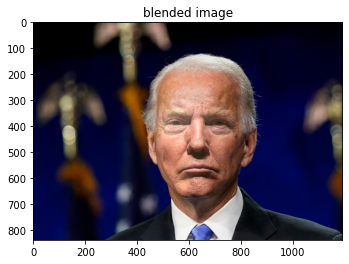

In [86]:
final_r = np.zeros((row, colum), dtype=np.float32)
final_g = np.zeros((row, colum), dtype=np.float32)
final_b = np.zeros((row, colum), dtype=np.float32)

res_r = spsolve(coe_mat, b_r)
res_g = spsolve(coe_mat, b_g)
res_b = spsolve(coe_mat, b_b)


final_r = np.array(res_r.reshape(row, colum), dtype=np.float32)
final_r[final_r > 255] = 255
final_r[final_r < 0] = 0


final_g = np.array(res_g.reshape(row, colum), dtype=np.float32)
final_g[final_g > 255] = 255
final_g[final_g < 0] = 0


final_b = np.array(res_b.reshape(row, colum), dtype=np.float32)
final_b[final_b > 255] = 255
final_b[final_b < 0] = 0


final_im = np.zeros_like(source_image)
final_im[:, :, 0] = final_b
final_im[:, :, 1] = final_g
final_im[:, :, 2] = final_r

plt.imsave('res07.jpg', np.uint8(final_im))
plt.imshow(np.uint8(final_im))
plt.title("blended image")